In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from ontologize.ontology import build_ontology
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Set ATP maintenance flux to 3
model.reactions.get_by_id("ATPM").lower_bound = 3
model.reactions.get_by_id("ATPM").upper_bound = 3

# Load E coli model
ECOLI_MODEL_FILE = "../model/ecoli.xml"
ecoli = read_sbml_model(ECOLI_MODEL_FILE)
ecoli_ex_glc = ecoli.reactions.get_by_id("GLC_p_EXCHANGE_RXN")
ecoli_ex_ace = ecoli.reactions.get_by_id("ACET_p_EXCHANGE_RXN")

# change compartments to match r pom convention
for metabolite in ecoli.metabolites:
    if metabolite.id[-2] == "_":
        comp = metabolite.id[-1]
        metabolite.id = metabolite.id[:-2] + f"[{comp}]"
    else:
        metabolite.id = metabolite.id.replace("CCO-PM-BAC-NEG", "[p]")

    # change underscores to dashes to match r pom convention
    metabolite.id = metabolite.id.replace("_", "-")

# Can't grow if certain metabolites included - remove them
b = ecoli.reactions.get_by_id("BIOMASS_EQUATION")
bad_guys = ["KDO2-LIPID-IVA[e]",
            "MET-tRNAs[c]",
            "Charged-MET-tRNAs[c]"
            ]
bad_guys = [ecoli.metabolites.get_by_id(bastard) for bastard in bad_guys]

b.add_metabolites({bastard : -b.metabolites[bastard] for bastard in bad_guys})


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [80]:
CARBONS_PER_GLUCOSE = 6
CARBONS_PER_ACETATE = 2

# Get glucose fluxome
with model:
    ex_glc.lower_bound = -5 / CARBONS_PER_GLUCOSE
    sol = model.optimize()
    glc_fluxes = sol.fluxes

# Get acetate fluxes
with model:
    ex_ace.lower_bound = -5 / CARBONS_PER_ACETATE
    sol = model.optimize()
    ace_fluxes = sol.fluxes

# Get names of reactions
rxn_names = glc_fluxes.index.values

In [ ]:
import plotly.graph_objects as go
from ipywidgets import widgets

# Create figure
pathways_data = pd.DataFrame([
    {
        0: name,
        1: pathways
    }
    for name, pathways in
    zip(rxn_names, [model.reactions.get_by_id(
        rxn).notes.get("pathways", "") for rxn in rxn_names])
])

pathways_of_interest = {
    "ethylmalonyl-CoA pathway": "red",
    "TCA cycle I (prokaryotic)": "purple",
    'glycolysis III (from glucose)': "blue",
    'Entner-Doudoroff pathway I': "green"
}
def wrap(pathways):
    if isinstance(pathways, list):
        return pathways
    return [pathways]
pathway_colors = [
    ([
        pathways_of_interest.get(p, "gray")
        for p in wrap(model.reactions.get_by_id(rxn).notes.get("pathways", []))
    ]
        + ["gray"]
    )[0]
    for rxn in rxn_names]

fig = go.FigureWidget([
    go.Scatter(
        x=glc_fluxes,
        y=ace_fluxes,
        mode="markers",
        marker=dict(
            color=pathway_colors,
            opacity=0.5
        ),
        customdata=pathways_data
    )
])

fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[0]}</b>",
        "pathways: %{customdata[1]}"
    ]))

# Text area widget to display selected points
selected_data_text = widgets.Textarea(
    value='Selected data will appear here',
    layout={'width': '50%', 'height': '200px'}
)

# Callback function to be called on selection


def selection_fn(trace, points, selector):
    if points.point_inds:
        inds = points.point_inds
        # selected_data = f"Selected indices: {inds}\nSelected x: {[X.values[i] for i in inds]}\nSelected y: {[Y.values[i] for i in inds]}"
        # selected_data = "\n".join(f"{[rxn_names[i] for i in inds]}\tX.values[i]\tY.values[i]")
        selected_data = "\n".join(
            f"{rxn_names[i]} : {model.reactions.get_by_id(rxn_names[i]).notes.get('pathways', [])}" for i in inds)
        selected_data_text.value = selected_data
    else:
        selected_data_text.value = 'No data selected'


# Link the selection callback to the scatter plot
fig.data[0].on_selection(selection_fn)

# Display the plot and the text area widget
# fig.write_html("img/scatter_interactive.html")
display(fig)
display(selected_data_text)

FigureWidget({
    'data': [{'customdata': array([['1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN',
                                    list(['PWY-5667', 'PWY0-1319'])],
                                   ['1.1.1.178-RXN', ''],
                                   ['1.1.1.262-RXN', ''],
                                   ...,
                                   ['RXN0-1132',
                                    list(['PWY-5084', 'GLYCLEAV-PWY', 'PWY-5046', 'PYRUVDEHYD-PWY'])],
                                   ['CYTOCHROME-C-OXIDASE-RXN', list(['PWY-3781', 'PWY-7279'])],
                                   ['1.10.2.2-RXN', list(['PWY-3781', 'PWY-7279'])]], dtype=object),
              'hovertemplate': '<b>%{customdata[0]}</b><br>pathways: %{customdata[1]}',
              'marker': {'color': [gray, gray, gray, ..., gray, gray, gray],
                         'opacity': 0.5},
              'mode': 'markers',
              'type': 'scatter',
              'uid': '1a876521-62dc-4201-8599-86477bfd16cc',


Textarea(value='Selected data will appear here', layout=Layout(height='200px', width='50%'))

In [82]:
# Get fluxes for E coli:
# Get glucose fluxome

ecoli_ex_oxygen = ecoli.reactions.get_by_id("OXYGEN___95_95___MOLECULE_p_EXCHANGE_RXN")
ecoli_ex_oxygen.upper_bound = 20
with ecoli:
    ecoli_ex_glc.lower_bound = -5 / CARBONS_PER_GLUCOSE
    sol = ecoli.optimize()
    ecoli_glc_fluxes = sol.fluxes

# Get acetate fluxes
with ecoli:
    ecoli_ex_ace.lower_bound = -5 / CARBONS_PER_ACETATE
    sol = ecoli.optimize()
    ecoli_ace_fluxes = sol.fluxes

# Get names of reactions
ecoli_rxn_names = ecoli_glc_fluxes.index.values

In [83]:
# Interactive scatterplot with plotly

fig = px.scatter(x=ecoli_glc_fluxes, y=ecoli_ace_fluxes, labels={'x': 'glc_fluxes', 'y': 'ace_fluxes'}, hover_name=ecoli_rxn_names, opacity=0.5)
fig.show()

In [84]:
from cobra.io import load_model
# Repeat with E coli core model to confirm

# Load E coli model
ecoli_core = load_model("iJO1366")
ecoli_core_ex_glc = ecoli_core.reactions.get_by_id("EX_glc__D_e")
ecoli_core_ex_ace = ecoli_core.reactions.get_by_id("EX_ac_e")
ecoli_core_ex_oxy = ecoli_core.reactions.get_by_id("EX_o2_e")
ecoli_core_ex_oxy.lower_bound = -20

# Get glucose fluxome
with ecoli_core:
    ecoli_core_ex_glc.lower_bound = -5 / CARBONS_PER_GLUCOSE
    sol = ecoli_core.optimize()
    ecoli_core_glc_fluxes = sol.fluxes

# Get acetate fluxes
with ecoli_core:
    ecoli_core_ex_glc.lower_bound = 0
    ecoli_core_ex_ace.lower_bound = -5 / CARBONS_PER_ACETATE
    sol = ecoli_core.optimize()
    ecoli_core_ace_fluxes = sol.fluxes

# Get names of reactions
ecoli_core_rxn_names = ecoli_core_glc_fluxes.index.values

# Interactive scatterplot with plotly
fig = px.scatter(x=ecoli_core_glc_fluxes, y=ecoli_core_ace_fluxes, labels={'x': 'glc_fluxes', 'y': 'ace_fluxes'}, hover_name=ecoli_core_rxn_names, opacity=0.5)
fig.show()

In [85]:
ecoli_core

Name,iJO1366
Memory address,7f22d1146380
Number of metabolites,1805
Number of reactions,2583
Number of genes,1367
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [86]:
# Create mapping for common metabolites between rpom and e coli models

metabolites_data = pd.DataFrame([
    {"id" : met.id,
    "source" : "rpom",
    "link": None,
    "rpom_reactions" : len(met.reactions),
    "ecoli_reactions" : 0}
    for met in model.metabolites])

unmatched_metabolites = []
for metabolite in ecoli.metabolites:
    matches = (metabolites_data["id"] == metabolite.id)
    metabolites_data["link"][matches] = metabolite.id
    metabolites_data["ecoli_reactions"][matches] = len(metabolite.reactions)

    if not any(matches):
        unmatched_metabolites.append({"id": metabolite.id, "source" : "ecoli", "link" : None, "rpom_reactions" : 0, "ecoli_reactions" : len(metabolite.reactions)})

metabolites_data = pd.concat([metabolites_data, pd.DataFrame(unmatched_metabolites)])

metabolites_data["has_link"] = ~metabolites_data["link"].isnull()
metabolites_data[["source", "has_link"]].groupby(["source", "has_link"]).size()
# ecoli_met_ids = {met.id : met for met in ecoli.metabolites}
# common_met_encoding = {}
# i = 0
# for met in model.metabolites:
#     if met.id in ecoli_met_ids:
#         common_met_encoding[met.id] = i
#         i += 1

# len(rpom_to_ecoli_mets)

/tmp/ipykernel_21418/1164973836.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21418/1164973836.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



source  has_link
ecoli   False       2784
rpom    False        799
        True         897
dtype: int64

In [87]:
# Create a common metabolite encoding (numbering) so as to match reactions
common_met_encoding = {met: i for i, met in enumerate(metabolites_data[metabolites_data["has_link"]]["id"])}

In [88]:
def encode_reaction(reaction, metabolite_encoding):
    def freeze_encoding(encoding):
        keylist = list(encoding.keys())
        valuelist = list(encoding.values())
        
        order = np.argsort(keylist)
        return tuple(f"{keylist[i]}:{valuelist[i]}" for i in order)
    
    try:
        encoding_fwd = {metabolite_encoding[met.id] : coeff for met, coeff in reaction.metabolites.items()}
        encoding_rev = {metabolite_encoding[met.id] : -coeff for met, coeff in reaction.metabolites.items()}
        return freeze_encoding(encoding_fwd), freeze_encoding(encoding_rev)
    except KeyError:
        # One or more metabolites are not in the common encoding
        return None, None


reaction_data = pd.DataFrame([
    {"id" : reaction.id,
    "source" : "rpom",
    "stoich_fwd" : encode_reaction(reaction, common_met_encoding)[0],
    "stoich_rev" : encode_reaction(reaction, common_met_encoding)[1],
    "rpom_glc_flux" : glc_fluxes[reaction.id],
    "rpom_ace_flux" : ace_fluxes[reaction.id],
    "link": None,
    "ecoli_glc_flux" : None,
    "ecoli_ace_flux" : None}
    for reaction in model.reactions])

unmatched_reactions = []
for reaction in ecoli.reactions:
    enc_fwd, enc_rev = encode_reaction(reaction, common_met_encoding)
    matches = reaction_data["stoich_fwd"] == enc_fwd

    if matches.any() and reaction_data["link"][matches].values[0] is not None:
        print(f"{reaction} matches with {reaction_data['id'][matches].values[0]} which already has match {reaction_data['link'][matches].values[0]}")

    reaction_data["link"][matches] = reaction.id
    reaction_data["ecoli_glc_flux"][matches] = ecoli_glc_fluxes[reaction.id]
    reaction_data["ecoli_ace_flux"][matches] = ecoli_ace_fluxes[reaction.id]

    if not any(matches):
        unmatched_reactions.append({
            "id" : reaction.id,
            "source": "ecoli",
            "stoich_fwd" : enc_fwd,
            "stoich_rev" : enc_rev,
            "rpom_glc_flux" : None,
            "rpom_ace_flux" : None,
            "link" : None,
            "ecoli_glc_flux" : ecoli_glc_fluxes[reaction.id],
            "ecoli_ace_flux" : ecoli_ace_fluxes[reaction.id]})

reaction_data = pd.concat([reaction_data, pd.DataFrame(unmatched_reactions)])
reaction_data["has_link"] = ~reaction_data["link"].isnull()
reaction_data.groupby(["source", "has_link"]).size()

/tmp/ipykernel_21418/2668229035.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21418/2668229035.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21418/2668229035.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ATPASE_RXN: ATP[c] + WATER[c] --> ADP[c] + PROTON[c] + Pi[c] matches with ATPASE-RXN which already has match ABC_42_RXN_CPD_15629/ATP/WATER//CPD_15629/ADP/Pi/PROTON__46_46__
TRANS_RXN_145: WATER[p] <=> WATER[c] matches with H2Otpp which already has match TRANS_RXN0_547[CCO_PM_BAC_NEG]_WATER//WATER.29.
TRANS_RXN_283: ATP[c] + BETAINE[p] + WATER[c] --> ADP[c] + BETAINE[c] + PROTON[c] + Pi[c] matches with TRANS-RXN-283 which already has match RXN_8638_BETAINE/ATP/WATER//BETAINE/ADP/Pi/PROTON.41.
TRANS_RXN_324: ATP[c] + CPD-821[p] + WATER[c] --> ADP[c] + CPD-821[c] + PROTON[c] + Pi[c] matches with RXN-8638-CPD-821/ATP/WATER//CPD-821/ADP/Pi/PROTON.41. which already has match RXN_8638_CPD_821/ATP/WATER//CPD_821/ADP/Pi/PROTON.41.


source  has_link
ecoli   False       3481
rpom    False       1389
        True         595
dtype: int64

In [89]:
reaction_data["has_encoding"] = ~reaction_data["stoich_fwd"].isnull()
reaction_data.groupby(["source", "has_encoding"]).size()

source  has_encoding
ecoli   False           3027
        True             454
rpom    False            911
        True            1073
dtype: int64

In [90]:
# E. coli glucose vs. R. pom glucose

import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets

subset_data = reaction_data[reaction_data["has_link"]]

# Add small positive value to prevent log(0)
subset_data["rpom_flux_adj"] = 1e-18 + subset_data["rpom_glc_flux"].abs()
subset_data["ecoli_flux_adj"] = 1e-18 + subset_data["ecoli_glc_flux"].abs()

subset_data["reaction_str"] = [model.reactions.get_by_id(rxn).reaction for rxn in subset_data["id"]]
fig = px.scatter(subset_data,
                 x="rpom_flux_adj",
                 y="ecoli_flux_adj",
                 custom_data=subset_data[["id", "reaction_str", "rpom_glc_flux", "ecoli_glc_flux"]],
                 labels={
                    "rpom_flux_adj" : "|Flux (<i>R. pom</i>), Glucose|",
                    "ecoli_flux_adj" : "|Flux (<i>E. coli</i>), Glucose|"
                 },
                 log_x = True,
                 log_y = True,
                 opacity=0.5)
fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[0]}</b>",
        "rpom flux: %{customdata[2]}",
        "ecoli flux: %{customdata[3]}",
        "rxn: %{customdata[1]}"
    ]))

# fig.update_yaxes(range=[abs(subset_data["ecoli_flux"][subset_data["ecoli_flux"] != 0].min()), subset_data["ecoli_flux"].max()])

fig.update_layout(
    width=800,
    height=600,
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
    xaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
)

/tmp/ipykernel_21418/1761086945.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21418/1761086945.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21418/1761086945.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
import plotly.graph_objects as go
from ipywidgets import widgets
# from ipywidgets.embed import embed_minimal_html


subset_data = reaction_data[reaction_data["has_link"]].copy()

# Add small positive value to prevent log(0)
subset_data["rpom_flux_adj"] = 1e-18 + subset_data["rpom_glc_flux"].abs()
subset_data["ecoli_flux_adj"] = 1e-18 + subset_data["ecoli_glc_flux"].abs()

subset_data["reaction_str"] = [model.reactions.get_by_id(rxn).reaction for rxn in subset_data["id"]]
X = subset_data["rpom_glc_flux"]
Y = subset_data["ecoli_glc_flux"]
X_adj = subset_data["rpom_flux_adj"]
Y_adj = subset_data["ecoli_flux_adj"]

fig = go.FigureWidget([
    go.Scatter(
        x=X_adj,
        y=Y_adj,
        mode="markers",
        marker=dict(
            opacity=0.5
        ),
        customdata=subset_data[["id", "reaction_str", "rpom_glc_flux", "ecoli_glc_flux"]],
    )
])

fig.update_xaxes(type="log")
fig.update_yaxes(type="log")

fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[0]}</b>",
        "rpom flux: %{customdata[2]}",
        "ecoli flux: %{customdata[3]}",
        "rxn: %{customdata[1]}"
    ]))

fig.update_layout(
    width=800,
    height=600,
    xaxis_title="|Flux (<i>R. pom</i>)|",
    yaxis_title="|Flux (<i>E. coli</i>)|",
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
    xaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
)

# Text area widget to display selected points
selected_data_text = widgets.Textarea(
    value='Selected data will appear here',
    layout={'width': '50%', 'height': '200px'}
)

# Callback function to be called on selection
def selection_fn(trace, points, selector):
    if points.point_inds:
        inds = points.point_inds
        # selected_data = f"Selected indices: {inds}\nSelected x: {[X.values[i] for i in inds]}\nSelected y: {[Y.values[i] for i in inds]}"
        selected_data = "\n".join(f"{subset_data['id'].values[inds]}\tX.values[i]\tY.values[i]")
        selected_data = "\n".join(f"{rxnid}\t{x}\t{y}" for rxnid, x, y in zip(subset_data['id'].values[inds], X.values[inds], Y.values[inds]))
        selected_data_text.value = selected_data
    else:
        selected_data_text.value = 'No data selected'

# Link the selection callback to the scatter plot
fig.data[0].on_selection(selection_fn)

# Display the plot and the text area widget
# fig.write_html("img/scatter_interactive.html")
display(fig)
display(selected_data_text)

FigureWidget({
    'data': [{'customdata': array([['1.1.1.8-RXN',
                                    'DIHYDROXY-ACETONE-PHOSPHATE[c] + NADH[c] + PROTON[c] --> GLYCEROL-3P[c] + NAD[c]',
                                    0.0, 0.20535486586057256],
                                   ['1.8.4.8-RXN',
                                    'PAPS[c] + Red-Thioredoxin[c] --> 3-5-ADP[c] + Ox-Thioredoxin[c] + 2.0 PROTON[c] + SO3[c]',
                                    0.015505528254010796, 0.0],
                                   ['2-DEHYDROPANTOATE-REDUCT-RXN',
                                    '2-DEHYDROPANTOATE[c] + NADPH[c] + PROTON[c] --> L-PANTOATE[c] + NADP[c]',
                                    4.365065389706768e-05, 0.0008506119945326186],
                                   ...,
                                   ['XMPXAN-RXN',
                                    'WATER[c] + XANTHOSINE-5-PHOSPHATE[c] --> Pi[c] + XANTHOSINE[c]', 0.0,
                                    0.0],
       

Textarea(value='Selected data will appear here', layout=Layout(height='200px', width='50%'))

In [92]:
subset_data[["id", "reaction_str", "rpom_glc_flux", "ecoli_glc_flux"]]

,id,reaction_str,rpom_glc_flux,ecoli_glc_flux
4,1.1.1.8-RXN,DIHYDROXY-ACETONE-PHOSPHATE[c] + NADH[c] + PRO...,0.000000,0.205355
30,1.8.4.8-RXN,PAPS[c] + Red-Thioredoxin[c] --> 3-5-ADP[c] + ...,0.015506,0.0
35,2-DEHYDROPANTOATE-REDUCT-RXN,2-DEHYDROPANTOATE[c] + NADPH[c] + PROTON[c] --...,0.000044,0.000851
36,2-ISOPROPYLMALATESYN-RXN,2-KETO-ISOVALERATE[c] + ACETYL-COA[c] + WATER[...,0.028371,0.665325
38,2-METHYLCITRATE-DEHYDRATASE-RXN,CPD-622[c] --> CPD-1136[c] + WATER[c],0.000000,0.0
...,...,...,...,...
1917,XANPRIBOSYLTRAN-RXN,PRPP[c] + XANTHINE[c] --> PPI[c] + XANTHOSINE-...,0.000000,0.0
1918,XANTHOSINEPHOSPHORY-RXN,Pi[c] + XANTHOSINE[c] --> RIBOSE-1P[c] + XANTH...,0.000000,0.0
1919,XMPXAN-RXN,WATER[c] + XANTHOSINE-5-PHOSPHATE[c] --> Pi[c]...,0.000000,0.0
1980,RXN0-1133,CO-A[c] + Pyruvate-dehydrogenase-acetylDHlipoy...,0.000000,0.0


In [93]:
# E. coli acetate vs. R. pom acetate

import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets

subset_data = reaction_data[reaction_data["has_link"]]

# Add small positive value to prevent log(0)
subset_data["rpom_flux_adj"] = 1e-18 + subset_data["rpom_ace_flux"].abs()
subset_data["ecoli_flux_adj"] = 1e-18 + subset_data["ecoli_ace_flux"].abs()

subset_data["reaction_str"] = [model.reactions.get_by_id(rxn).reaction for rxn in subset_data["id"]]
fig = px.scatter(subset_data,
                 x="rpom_flux_adj",
                 y="ecoli_flux_adj",
                 custom_data=subset_data[["id", "reaction_str", "rpom_ace_flux", "ecoli_ace_flux"]],
                 labels={
                    "rpom_flux_adj" : "|Flux (<i>R. pom</i>), Acetate|",
                    "ecoli_flux_adj" : "|Flux (<i>E. coli</i>), Acetate|"
                 },
                 log_x = True,
                 log_y = True,
                 opacity=0.5)
fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[0]}</b>",
        "rpom flux: %{customdata[2]}",
        "ecoli flux: %{customdata[3]}",
        "rxn: %{customdata[1]}"
    ]))

# fig.update_yaxes(range=[abs(subset_data["ecoli_flux"][subset_data["ecoli_flux"] != 0].min()), subset_data["ecoli_flux"].max()])

fig.update_layout(
    width=800,
    height=600,
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
    xaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
)

/tmp/ipykernel_21418/3917828235.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21418/3917828235.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21418/3917828235.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 

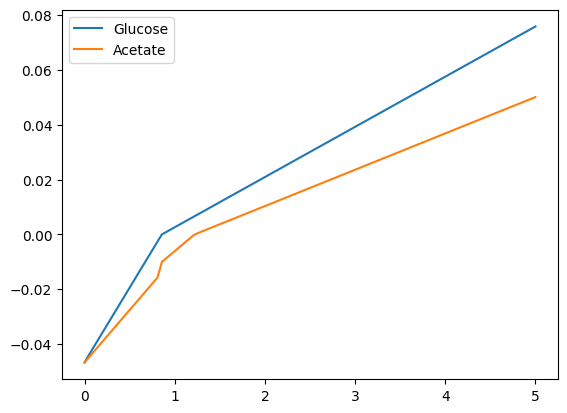

In [94]:
# Growth rate vs. supply rate
fig, ax = plt.subplots()

glc_growth = []
ace_growth = []
supply = np.linspace(0, 5, 100)
for supply_rate in supply:
    with model:
        ex_glc.lower_bound = -supply_rate / CARBONS_PER_GLUCOSE
        glc_growth.append(model.optimize().objective_value)
    with model:
        ex_ace.lower_bound = -supply_rate / CARBONS_PER_ACETATE
        ace_growth.append(model.optimize().objective_value)

ax.plot(supply, glc_growth, label="Glucose")
ax.plot(supply, ace_growth, label="Acetate")
ax.legend()

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 'infeasible'.

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning:

Solver status is 

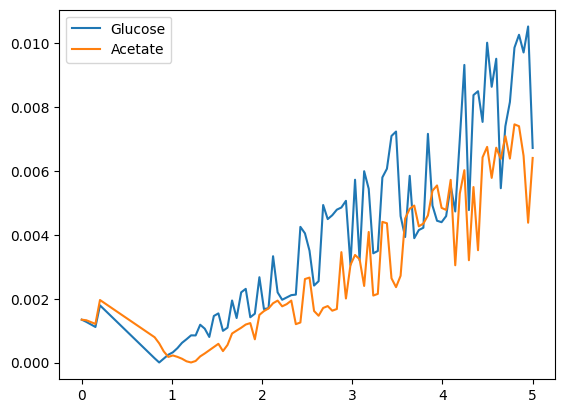

In [95]:
# Median flux vs. supply rate
fig, ax = plt.subplots()

glc_median = []
ace_median = []
supply = np.linspace(0, 5, 100)
for supply_rate in supply:
    with model:
        ex_glc.lower_bound = -supply_rate / CARBONS_PER_GLUCOSE
        fluxes = model.optimize().fluxes
        fluxes = fluxes[fluxes != 0].abs()
        glc_median.append(fluxes.median())
    with model:
        ex_ace.lower_bound = -supply_rate / CARBONS_PER_ACETATE
        fluxes = model.optimize().fluxes
        fluxes = fluxes[fluxes != 0].abs()
        ace_median.append(fluxes.median())

ax.plot(supply, glc_median, label="Glucose")
ax.plot(supply, ace_median, label="Acetate")
ax.legend()